In [ ]:
#@title 1) Libraries import
##Librerias para análisis estadistico y matemático
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lti
from scipy.stats import expon
import scipy.fftpack as fourier
from scipy.fftpack import fft, fftfreq, fftshift
import seaborn as sns ##Histograms
from numpy import logspace
import sympy as sym
import numpy as np
from scipy.optimize import minimize

In [ ]:
!pip install lcapy
from lcapy import Circuit, j, omega, s

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#@title 2) Circuit Design
ctt=Circuit(
'''
    Vi 1 0_1 step; down
    C1 1 2; right, size=1.5
    R1 2 0; down, size=1.5
    C2 2 3; right, size=1.5
    R3 2 3; right, offset=0.7
    R2 3 0_3; down
    W 0_1 0; right
    W 0 0_3; right
'''
)

#ctt.draw()

In [ ]:
H=(ctt.R2.V(s)/ctt.Vi.V(s)).simplify()
H

                            C₁⋅R₁⋅R₂⋅s⋅(C₂⋅R₃⋅s + 1)                          
──────────────────────────────────────────────────────────────────────────────
                2                                                             
C₁⋅C₂⋅R₁⋅R₂⋅R₃⋅s  + R₁ + R₂ + R₃ + s⋅(C₁⋅R₁⋅R₂ + C₁⋅R₁⋅R₃ + C₂⋅R₁⋅R₃ + C₂⋅R₂⋅R

  
──
  
₃)

In [ ]:
C1=4.7e-4
C2=4.7e-4
R1=1000
R2=2000
R3=500

In [ ]:
#@title 3) High pass filter transfer function
H_valores=H.subs('C1', C1).subs('C2', C2).subs('R1', R1).subs('R2',R2).subs('R3', R3)

Text(0, 0.5, 'Magnitud (dB)')

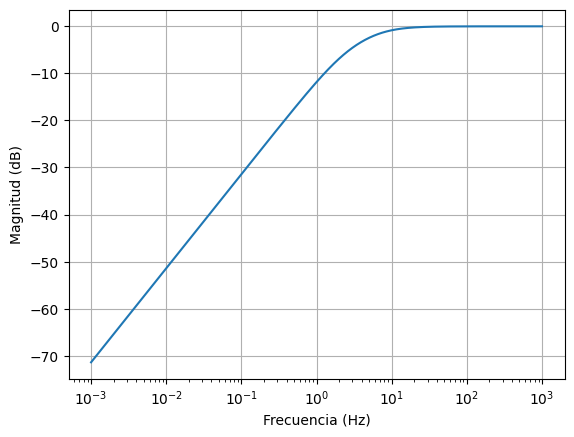

In [ ]:
W=logspace(-3,3,2000) ##GENERAMOS VECTOR DE FRECUENCIAS
X=H_valores(j*omega).dB.plot(W, log_frequency=True)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud (dB)')

In [ ]:
##Usando LTI para simular en tiempo
Coeficientes_num=[C1*R1*R2*C2*R3,C1*R1*R2, 0]
Coeficientes_den=[C1*C2*R1*R2*R3, C1*R1*R2+C1*R1*R3+C2*R1*R3+C2*R2*R3, R1+R2+R3]

In [ ]:
#@title 4) Impluse response
lti_system=lti(Coeficientes_num, Coeficientes_den)          #Simulando sistema slit
N=4096          #Definiendo numero de muestras
t1, h=lti_system.impulse(N)              #obteneindo respuesta al impulso

In [ ]:
# Definimos la función de log-verosimilitud
def log_likelihood(params, x):
    mu, sigma = params
    N = len(x)
    log_likelihood = -(N/2)*np.log(2*np.pi*sigma**2) - np.sum((x-mu)**2)/(2*sigma**2)
    return log_likelihood

Text(0, 0.5, 'Amplitud')

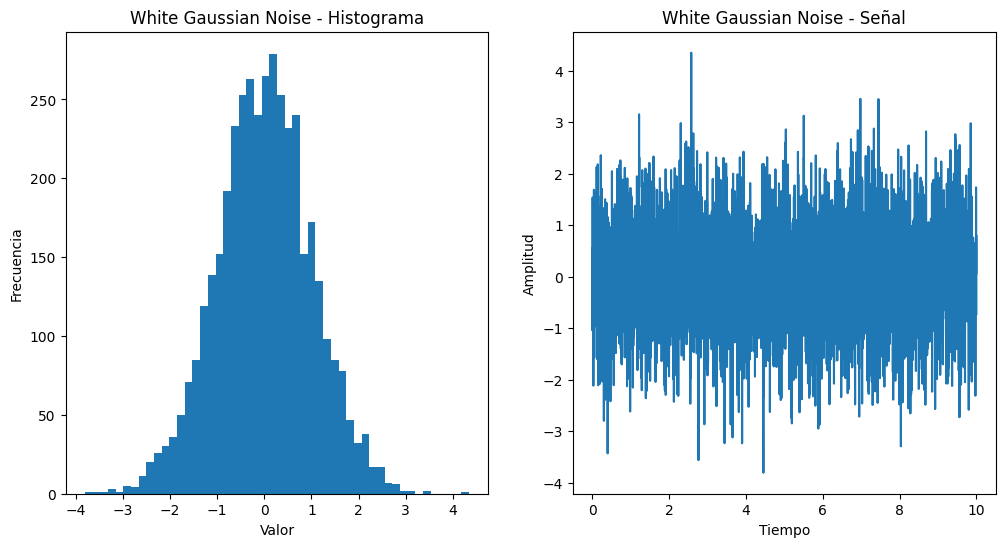

In [ ]:
#@title 4)Creating a normal distribution
# Definimos la muestra de datos
mu, sigma = 0, 1 # media y desvio estandar
N=4096
t=np.linspace(0, 10, N)


ND = np.random.normal(mu, sigma, N) #creando muestra de datos

# Crear figura y subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Gráfico del histograma
axs[0].set_title(r'White Gaussian Noise - Histograma')
axs[0].hist(ND, 50)
axs[0].set_xlabel('Valor')
axs[0].set_ylabel('Frecuencia')

# Gráfico de la señal
axs[1].set_title('White Gaussian Noise - Señal')
axs[1].plot(t, ND)
axs[1].set_xlabel('Tiempo')
axs[1].set_ylabel('Amplitud')

In [ ]:
#@title 5) Inputs parameters estimation
# Definimos la función a minimizar (el negativo de la función de log-verosimilitud)
def neg_log_likelihood(params, x):
    return -log_likelihood(params, x)

# Minimizamos la función de neg-log-verosimilitud para obtener los parámetros óptimos
result = minimize(neg_log_likelihood, [1, 1], args=(ND,))
mu_optimo, sigma_optimo = result.x

print("Los parámetros óptimos son: mu = ", mu_optimo, " sigma = ", sigma_optimo)

Los parámetros óptimos son: mu =  0.006053930556962809  sigma =  1.0036165487472561


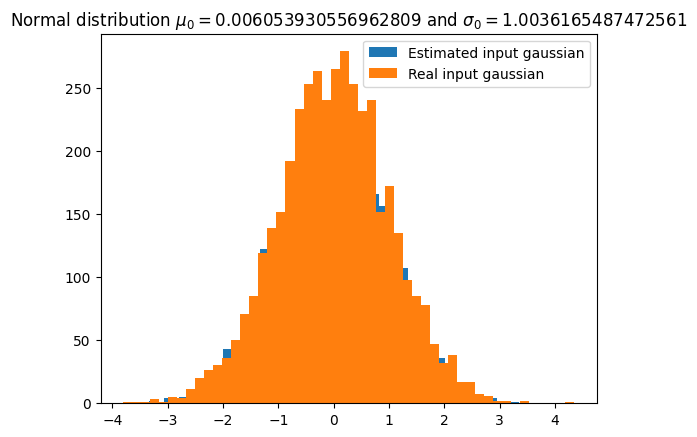

In [ ]:
GaussEst=np.random.normal(mu_optimo, sigma_optimo, N)
plt.title(f"Normal distribution $\mu_0 = {mu_optimo}$ and $\sigma_0 = {sigma_optimo}$")
plt.hist(GaussEst, 50, label='Estimated input gaussian')
plt.hist(ND, 50, label='Real input gaussian')
plt.legend()
plt.show()

Text(0.5, 0, 'Time')

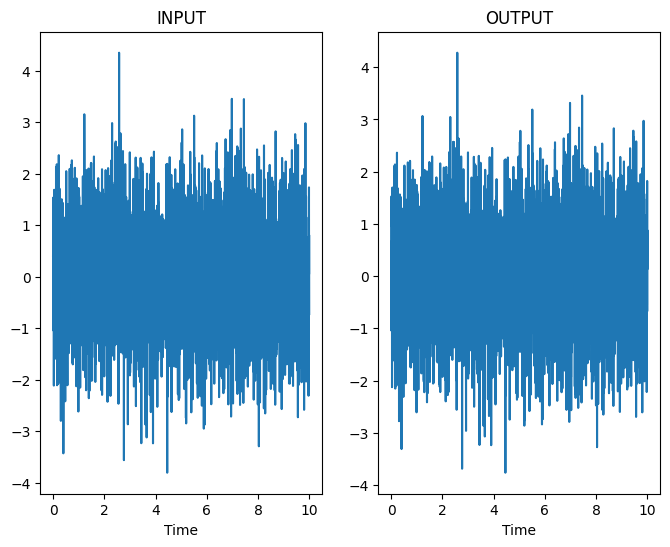

In [ ]:
##INGRESAMOS LA ENTRADA gaussiana A NUESTRO CIRCUITO:
_,Output_Circuit,_=lti_system.output(ND, t) ##SALIDA DEL CIRCUITO.

# COMPARAMOS ENTRADA VS SALIDA 
fig, axs = plt.subplots(1, 2,figsize=(8,6))
axs[0].plot(t, ND)
axs[0].set_title("INPUT")
axs[0].set_xlabel("Time")
axs[1].plot(t, Output_Circuit)
axs[1].set_title("OUTPUT")
axs[1].set_xlabel("Time")

El valor óptimo de mu es: -0.0016586363490000745
El valor óptimo de sigma es: 1.0015966286452598


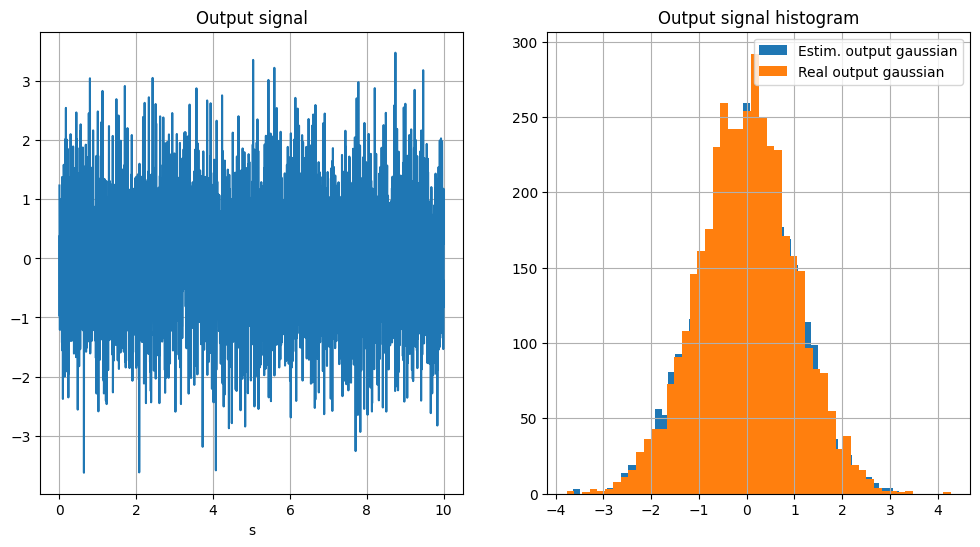

In [ ]:
#@title 6) Output parameters estimation
# Minimizamos la función de neg-log-verosimilitud para obtener los parámetros óptimos
result = minimize(neg_log_likelihood, [1, 1], args=(Output_Circuit,))
mu_opti, sigma_opti = result.x

print("El valor óptimo de mu es:", mu_opti)
print("El valor óptimo de sigma es:", sigma_opti)

GaussEstOut = np.random.normal(mu_opti, sigma_opti, N)

# Crear figura y subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].set_title('Output signal')
axs[0].set_xlabel('s') #Nombre del eje x 
axs[0].plot(t, GaussEstOut) #Gráfica de la señal con el tiempo en milisegundos
axs[0].grid() #Poner cuadricula

axs[1].set_title('Output signal histogram')
axs[1].hist(GaussEstOut, 50, label='Estim. output gaussian') #Gráfica de la señal con el tiempo en milisegundos
axs[1].hist(Output_Circuit, 50, label='Real output gaussian')
axs[1].grid() #Poner cuadricula
axs[1].legend()